In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357290 sha256=2d8daa603e2057d4d1183eec2f262b51a1e55c22e2a0f417015359e4a93aead4
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd

In [ ]:
ratings = pd.read_csv('Ratings.csv')
ratings.head(10)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [ ]:
ratings.shape

(1149780, 3)

In [ ]:
ratings.duplicated().sum()

0

In [ ]:
ratings.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

In [ ]:
meanOfRatings = ratings.groupby("ISBN")["Book-Rating"].mean()
meanOfRatings.sort_values(ascending=False).head(10)

ISBN
0874477050    10.0
561002010     10.0
0590939874    10.0
1570761914    10.0
56500624X     10.0
157076154X    10.0
1570761175    10.0
0373510365    10.0
0393092526    10.0
0590936026    10.0
Name: Book-Rating, dtype: float64

<Axes: >

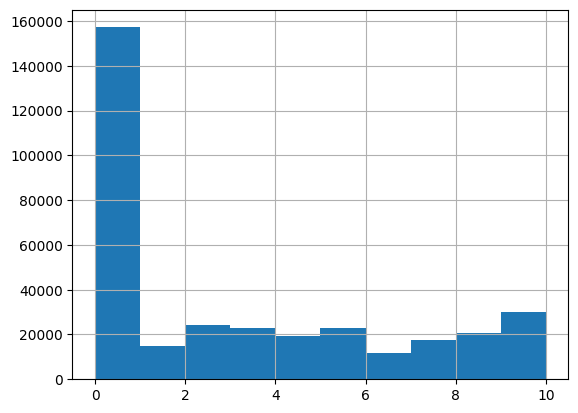

In [ ]:
meanOfRatings.hist()

In [ ]:
minRatings = 50
condition1 = ratings["ISBN"].value_counts() >= minRatings
condition1Index = condition1[condition1].index.to_list()

minUserRatings = 50
condition2 = ratings["User-ID"].value_counts() >= minUserRatings
condition2Index = condition2[condition2].index.to_list()

In [ ]:
filteredRatings = ratings[(ratings["ISBN"].isin(condition1Index)) & (ratings["User-ID"].isin(condition2Index))]
filteredRatings.head()

,User-ID,ISBN,Book-Rating
173,276847,0446364193,0
182,276847,3426029553,8
413,276925,002542730X,10
426,276925,0316666343,0
427,276925,0345391810,0


In [ ]:
filteredRatings.shape

(143240, 3)

In [ ]:
from surprise import Reader, Dataset
import surprise

reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(filteredRatings[["User-ID", "ISBN" , "Book-Rating"]], reader)

In [ ]:
from surprise.model_selection import cross_validate
from surprise import SVD

algo = SVD()
result = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.5586  3.5572  3.5391  3.5359  3.5656  3.5513  0.0116  
MAE (testset)     2.7197  2.7337  2.7202  2.7193  2.7476  2.7281  0.0111  
Fit time          1.86    1.93    1.95    1.97    2.73    2.09    0.32    
Test time         0.27    0.28    0.17    0.31    0.17    0.24    0.06    


In [ ]:
result["test_rmse"].mean()

3.5513097993540512

In [ ]:
from surprise import *
benchmark = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    result = cross_validate(algorithm, data, measures=['RMSE'], cv=3)
    meanError = result["test_rmse"].mean()
    finalResult = {"RMSE":meanError , "Algorithm":str(algorithm)}
    benchmark.append(finalResult)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [ ]:
min = 1000
index = 10
for item in benchmark:
  if(item["RMSE"] < min):
    min = item["RMSE"]
    index = benchmark.index(item)

In [ ]:
print(min)
print(benchmark[index]["Algorithm"])

3.3802653305340544


In [ ]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2)
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
surprise.accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3682


3.3682352157403903

In [ ]:
user = ["276725" , "0521795028"]
pred = algo.predict(user[0], user[1])
print(pred)

user: 276725     item: 0521795028 r_ui = None   est = 2.35   {'was_impossible': False}


In [ ]:
uid = 276847
bookList = filteredRatings["ISBN"].unique()
ratingsList = []
books = []
for item in bookList:
  books.append(item)
  rating = algo.predict(str(uid), str(item))
  ratingsList.append(rating[3])

In [ ]:
predDict = {"ISBN":books , "EstimatedRating":ratingsList}
finalPre = pd.DataFrame.from_dict(predDict)
finalPre.head(10)

,ISBN,EstimatedRating
0,0446364193,2.312298
1,3426029553,2.433231
2,002542730X,3.063340
3,0316666343,3.593391
4,0345391810,2.690124
5,0385504209,3.670749
6,0679745580,1.957232
7,0804106304,2.465124
8,0971880107,0.598993
9,0060964049,2.464805


In [ ]:
finalPre.sort_values("EstimatedRating" , ascending=False, inplace=True)
finalPre.head()

,ISBN,EstimatedRating
11,0439064864,5.901668
669,0439139597,5.811093
692,0590353403,5.673617
668,0439136350,5.652935
202,0877017883,5.507074
